In [43]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
%load_ext tensorboard
import tensorboard
tensorboard.__version__
from datetime import datetime


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Specify each path

In [44]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [45]:
NUM_CLASSES = 26

# Dataset reading

In [46]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [47]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [50]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 26)                286       
                                                                 
Total params: 1,356
Trainable params: 1,356
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [52]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Model training

In [54]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback,tensorboard_callback]
)

Epoch 1/1000
1/8 [==>...........................] - ETA: 4s - loss: 3.3310 - accuracy: 0.0391
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
8/8 [==============================] - 1s 53ms/step - loss: 3.3262 - accuracy: 0.0347 - val_loss: 3.2659 - val_accuracy: 0.0228
Epoch 2/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.3293 - accuracy: 0.0312
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
8/8 [==============================] - 0s 14ms/step - loss: 3.2971 - accuracy: 0.0271 - val_loss: 3.2486 - val_accuracy: 0.0130
Epoch 3/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.2900 - accuracy: 0.0312
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
8/8 [==============================] - 0s 15ms/step - loss: 3.2837 - accuracy: 0.0250 - val_loss: 3.2395 - val_accuracy: 0.0195
Epoch 4/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.2754 - accuracy: 0.0391
Epoch 4: sav

In [55]:
%tensorboard --logdir logs


Reusing TensorBoard on port 6006 (pid 17844), started 9:14:16 ago. (Use '!kill 17844' to kill it.)

In [56]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 3ms/step - loss: 1.7467 - accuracy: 0.4821


In [57]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [58]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 60ms/step
[1.92205012e-01 1.70693882e-02 1.08181335e-01 1.81014724e-02
 1.25716537e-01 1.31406626e-02 1.04677792e-05 1.42318726e-07
 3.48354317e-02 1.01208016e-02 1.79108977e-03 1.46186650e-02
 7.56460279e-02 5.23128361e-02 1.69965386e-01 2.20822333e-03
 1.72671173e-06 2.77263694e-03 5.36229163e-02 3.97423245e-02
 1.38915121e-03 8.80695647e-04 3.90607887e-03 2.93142963e-02
 2.41858773e-02 8.26075953e-03]
0


# Confusion matrix

10/10 [==============================] - 0s 1ms/step


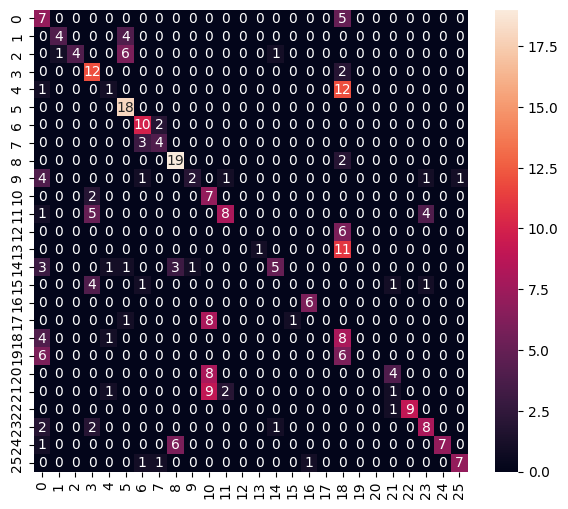

Classification Report
              precision    recall  f1-score   support

           0       0.24      0.58      0.34        12
           1       0.80      0.50      0.62         8
           2       1.00      0.33      0.50        12
           3       0.48      0.86      0.62        14
           4       0.25      0.07      0.11        14
           5       0.60      1.00      0.75        18
           6       0.62      0.83      0.71        12
           7       0.57      0.57      0.57         7
           8       0.68      0.90      0.78        21
           9       0.67      0.20      0.31        10
          10       0.22      0.78      0.34         9
          11       0.73      0.44      0.55        18
          12       0.00      0.00      0.00         6
          13       1.00      0.08      0.15        12
          14       0.71      0.36      0.48        14
          15       0.00      0.00      0.00         7
          16       0.86      1.00      0.92         6
     

c:\Users\bigdipper\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bigdipper\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bigdipper\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [60]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [61]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\BIGDIP~1\AppData\Local\Temp\tmpzvhbr7ue\assets


INFO:tensorflow:Assets written to: C:\Users\BIGDIP~1\AppData\Local\Temp\tmpzvhbr7ue\assets


7540

# Inference test

In [62]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [63]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [64]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [65]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms


In [66]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.92048326e-01 1.70783047e-02 1.08066730e-01 1.80886835e-02
 1.25879914e-01 1.31559335e-02 1.04419523e-05 1.41599159e-07
 3.48268710e-02 1.01117864e-02 1.78813667e-03 1.46072768e-02
 7.56410584e-02 5.23023605e-02 1.70205504e-01 2.20547034e-03
 1.72195053e-06 2.76721315e-03 5.36601432e-02 3.96822207e-02
 1.38580461e-03 8.79517815e-04 3.90453869e-03 2.92812604e-02
 2.41778996e-02 8.24276265e-03]
0


In [67]:
!tensorflowjs_converter --input_format=keras ./model/keypoint_classifier/keypoint_classifier.hdf5 ./model/tfjs_model